# Ferrari Performance over Time

In this part the performance of Ferrari will be investigated. The following questions should be answered:
1. How did the amount of Ferrari's wins develop?
3. How dependent are Ferrari's win on each drivers? # see possible spikes, compare if ever only constructors championship and not driver?
4. Did Ferrari's Qualifying results worsen?
5. Did Ferrari's Pit Stops improve?


In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("F1") \
    .getOrCreate()

25/05/18 18:56:22 WARN Utils: Your hostname, bdlc-004 resolves to a loopback address: 127.0.1.1; using 10.176.129.6 instead (on interface ens192)
25/05/18 18:56:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/18 18:56:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/18 18:56:23 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/05/18 18:56:23 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/05/18 18:56:23 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
25/05/18 18:56:23 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
25/05/18 18:56:23 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045

# Preperation

In [2]:
results_df = spark.read.parquet(f"/f1/data/cleaned_results.parquet")
constructors_df = spark.read.parquet(f"/f1/data/cleaned_constructors.parquet")
drivers_df = spark.read.parquet(f"/f1/data/cleaned_drivers.parquet")
constructor_standings_df = spark.read.parquet(f"/f1/data/cleaned_constructor_standings.parquet")
races_df = spark.read.parquet(f"/f1/data/cleaned_races.parquet")
driver_standings_df = spark.read.parquet(f"/f1/data/cleaned_driver_standings.parquet")

In [3]:
results_df.show(1)
constructors_df.show(1)
drivers_df.show(1)
constructor_standings_df.show(1)
races_df.show(1)
driver_standings_df.show(1)

+--------+------+--------+-------------+------+----+--------+------------+-------------+------+----+-----------+------------+----------+----+--------------+---------------+--------+
|resultId|raceId|driverId|constructorId|number|grid|position|positionText|positionOrder|points|laps|       time|milliseconds|fastestLap|rank|fastestLapTime|fastestLapSpeed|statusId|
+--------+------+--------+-------------+------+----+--------+------------+-------------+------+----+-----------+------------+----------+----+--------------+---------------+--------+
|       1|    18|       1|            1|    22|   1|       1|           1|            1|  10.0|  58|1:34:50.616|     5690616|        39|   2|      1:27.452|        218.300|       1|
+--------+------+--------+-------------+------+----+--------+------------+-------------+------+----+-----------+------------+----------+----+--------------+---------------+--------+
only showing top 1 row

+-------------+--------------+-------+-----------+
|constructorId|

# Ferrari Wins

1. How often did Ferrari drivers win a race?
2. How often did Ferrari drivers win the championship?
3. How often did Ferrari win the constructor's championship?

## Ferrari Drivers Wins

In [4]:
ferrari = constructors_df.where(constructors_df.name == "Ferrari").select("constructorId").first().constructorId
ferrari

6

Get all winners of each race.

In [5]:
first_places_df = results_df.join(drivers_df,
               results_df.driverId == drivers_df.driverId,
               "inner").join(races_df,
               races_df.raceId == results_df.raceId,
               "inner").where(results_df.position == 1)

first_places_df.select(first_places_df.surname, first_places_df.position, first_places_df.date).show(5)

+---------+--------+----------+
|  surname|position|      date|
+---------+--------+----------+
| Hamilton|       1|2008-03-16|
|Räikkönen|       1|2008-03-23|
|    Massa|       1|2008-04-06|
|Räikkönen|       1|2008-04-27|
|    Massa|       1|2008-05-11|
+---------+--------+----------+
only showing top 5 rows



Get all the Ferrari wins.

In [6]:
ferrari_wins_df = first_places_df.where(first_places_df.constructorId == ferrari)
ferrari_wins_df.select(first_places_df.surname, first_places_df.position, first_places_df.date).sort(ferrari_wins_df.date, ascending=False).show(5)

+-------+--------+----------+
|surname|position|      date|
+-------+--------+----------+
|  Sainz|       1|2024-10-27|
|Leclerc|       1|2024-10-20|
|Leclerc|       1|2024-09-01|
|Leclerc|       1|2024-05-26|
|  Sainz|       1|2024-03-24|
+-------+--------+----------+
only showing top 5 rows



Group them by year to get an overview of the wins over time.

In [7]:
from pyspark.sql.functions import count

ferrari_wins_per_year_df = ferrari_wins_df.groupBy("year").agg(count('*').alias('wins')).sort("year")
ferrari_wins_per_year_df.show(5)

+----+----+
|year|wins|
+----+----+
|1951|   3|
|1952|   7|
|1953|   7|
|1954|   2|
|1955|   1|
+----+----+
only showing top 5 rows



Now we would like to visualise that to see a development.

To have more context, these numbers will also be compared to the average amount of wins for all teams.

In [8]:
from pyspark.sql.functions import avg

others_wins_df = first_places_df.filter(first_places_df.constructorId != ferrari).groupBy("year", "constructorId").count().withColumnRenamed("count", "wins").orderBy("year", "wins", ascending=[True, False])
others_wins_df.show(5)

+----+-------------+----+
|year|constructorId|wins|
+----+-------------+----+
|1950|           51|   6|
|1950|          113|   1|
|1951|           51|   5|
|1951|          113|   1|
|1952|          114|   1|
+----+-------------+----+
only showing top 5 rows



In [9]:
others_average_wins_df = others_wins_df.groupBy("year").agg(avg('wins').alias('wins')).sort("year")
others_average_wins_df.show(5)

+----+------------------+
|year|              wins|
+----+------------------+
|1950|               3.5|
|1951|               3.0|
|1952|               1.0|
|1953|               1.0|
|1954|2.3333333333333335|
+----+------------------+
only showing top 5 rows



The difference between wins of Ferrari and the other teams should be compared nummerically and visually. only at least 1 win -?top teams

In [10]:
from pyspark.sql.functions import col, round as spark_round

others_df_renamed = others_average_wins_df.withColumnRenamed("wins", "others_wins")
ferrari_df_renamed = ferrari_wins_per_year_df.withColumnRenamed("wins", "ferrari_wins")

difference_df = (
    ferrari_df_renamed
    .join(others_df_renamed, on="year", how="inner")
    .withColumn("win_diff", col("ferrari_wins") - col("others_wins"))
    .orderBy("year")
)

difference_df.show()

+----+------------+------------------+-------------------+
|year|ferrari_wins|       others_wins|           win_diff|
+----+------------+------------------+-------------------+
|1951|           3|               3.0|                0.0|
|1952|           7|               1.0|                6.0|
|1953|           7|               1.0|                6.0|
|1954|           2|2.3333333333333335|-0.3333333333333335|
|1955|           1|               3.0|               -2.0|
|1956|           6|               1.5|                4.5|
|1958|           2|               3.0|               -1.0|
|1959|           2|2.3333333333333335|-0.3333333333333335|
|1960|           1|               3.0|               -2.0|
|1961|           5|               3.0|                2.0|
|1963|           1|               4.5|               -3.5|
|1964|           3|2.3333333333333335| 0.6666666666666665|
|1966|           2|              1.75|               0.25|
|1968|           1|3.6666666666666665|-2.666666666666666

In [13]:
from pyspark.sql.functions import when

df_with_periods = difference_df.withColumn(
    "period",
    when((col("year") >= 1950) & (col("year") <= 1974), "Early Years (1950-1974)")
    .when((col("year") >= 1975) & (col("year") <= 1999), "Mid Years (1975-1999)")
    .when((col("year") >= 2000) & (col("year") <= 2024), "Recent Years (2000-2024)")
)
grouped_by_period_df = df_with_periods.groupBy("period").agg(
    avg("ferrari_wins").alias("avg_ferrari_wins"),
    avg("others_wins").alias("avg_others_wins"),
    avg("win_diff").alias("avg_win_diff")
).orderBy("period")

print("\nAverage Values per Defined Period:")
grouped_by_period_df.show()


Average Values per Defined Period:
+--------------------+------------------+------------------+-------------------+
|              period|  avg_ferrari_wins|   avg_others_wins|       avg_win_diff|
+--------------------+------------------+------------------+-------------------+
|Early Years (1950...|2.9444444444444446|2.6620370370370368|0.28240740740740733|
|Mid Years (1975-1...|              3.65|               4.5|-0.8499999999999999|
|Recent Years (200...| 5.857142857142857| 6.939682539682541|-1.0825396825396827|
+--------------------+------------------+------------------+-------------------+



In [14]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

assembler = VectorAssembler(
            inputCols=["year"],
            outputCol="features"
        )
regression_input_df = assembler.transform(difference_df.select("year", "win_diff")) \
                               .select(col("features"), col("win_diff").alias("label"))

lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(regression_input_df)

# coefficient = slope
slope_value = lr_model.coefficients[0]

print(f"\nThe slope of 'win_diff' with respect to 'year' is: {slope_value}")

25/05/18 18:57:07 WARN Instrumentation: [144f0fde] regParam is zero, which might cause numerical instability and overfitting.
25/05/18 18:57:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/05/18 18:57:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
25/05/18 18:57:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK



The slope of 'win_diff' with respect to 'year' is: -0.06788054123603138


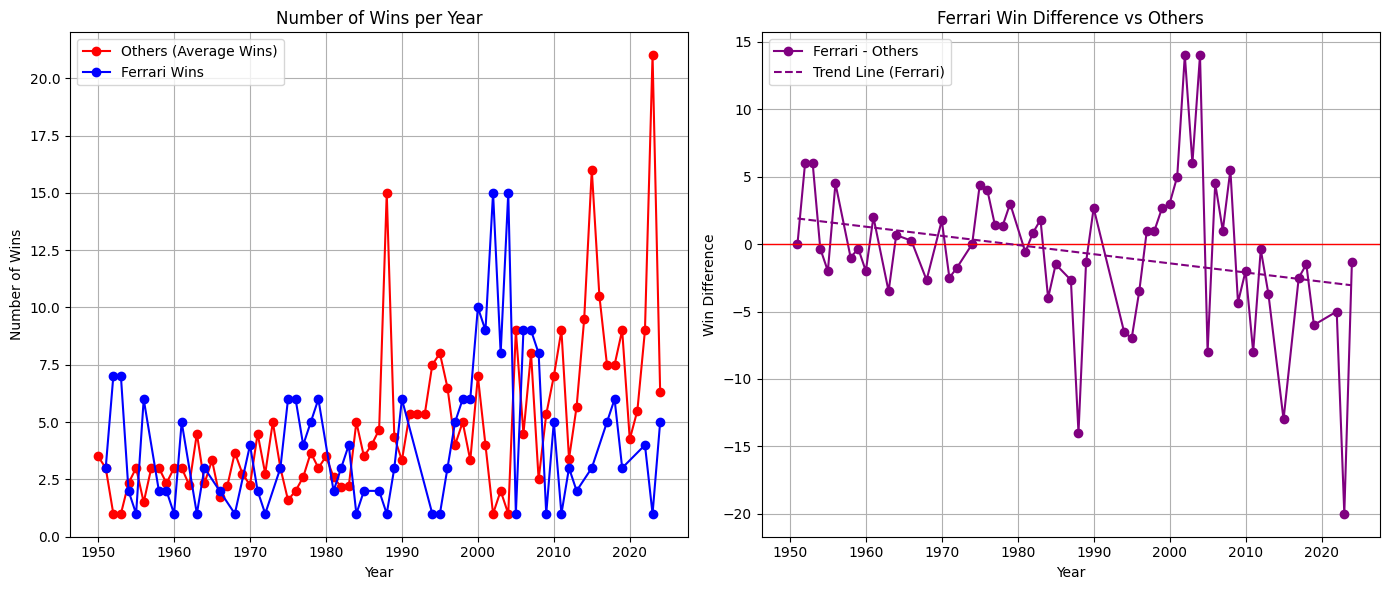

In [15]:
import matplotlib.pyplot as plt

others_average_wins_pdf = others_average_wins_df.toPandas()
ferrari_wins_per_year_pdf = ferrari_wins_per_year_df.toPandas()
difference_pdf = difference_df.toPandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

axes[0].plot(
    others_average_wins_pdf['year'],
    others_average_wins_pdf['wins'],
    marker='o',
    linestyle='-',
    color='red',
    label='Others (Average Wins)'
)
axes[0].plot(
    ferrari_wins_per_year_pdf['year'],
    ferrari_wins_per_year_pdf['wins'],
    marker='o',
    color='blue',
    linestyle='-',
    label='Ferrari Wins'
)
axes[0].set_title('Number of Wins per Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Wins')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(
    difference_pdf['year'],
    difference_pdf['win_diff'],
    marker='o',
    linestyle='-',
    color='purple',
    label='Ferrari - Others'
)
axes[1].axhline(y=0, color='red', linestyle='-', linewidth=1)
axes[1].set_title('Ferrari Win Difference vs Others')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Win Difference')

slope_value = lr_model.coefficients[0]
intercept_value = lr_model.intercept

years_for_plot = difference_pdf['year']
reg_line_predictions = [slope_value * yr + intercept_value for yr in years_for_plot]

axes[1].plot(
    years_for_plot,
    reg_line_predictions,
    color='purple',
    linestyle='--',
    label='Trend Line (Ferrari)'
)

axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

Additionally to the absolute number, the realtive numbers should be compared as well.

In [16]:
races_per_year = races_df.groupBy("year").agg(count('*').alias('races')).sort("year")
races_per_year.sort("year", ascending=False).show(5)

relative_ferrari_wins_df = (
    ferrari_wins_per_year_df
    .join(races_per_year, on="year", how="inner")
    .withColumn("relative_wins", col("wins") / col("races"))
    .orderBy("year")
)
relative_ferrari_wins_df.show(4)

relative_others_average_wins_df = (
    others_average_wins_df
    .join(races_per_year, on="year", how="inner")
    .withColumn("relative_wins", col("wins") / col("races"))
    .orderBy("year")
)
relative_others_average_wins_df.show(4)

+----+-----+
|year|races|
+----+-----+
|2024|   24|
|2023|   22|
|2022|   22|
|2021|   22|
|2020|   17|
+----+-----+
only showing top 5 rows

+----+----+-----+------------------+
|year|wins|races|     relative_wins|
+----+----+-----+------------------+
|1951|   3|    8|             0.375|
|1952|   7|    8|             0.875|
|1953|   7|    9|0.7777777777777778|
|1954|   2|    9|0.2222222222222222|
+----+----+-----+------------------+
only showing top 4 rows

+----+----+-----+------------------+
|year|wins|races|     relative_wins|
+----+----+-----+------------------+
|1950| 3.5|    7|               0.5|
|1951| 3.0|    8|             0.375|
|1952| 1.0|    8|             0.125|
|1953| 1.0|    9|0.1111111111111111|
+----+----+-----+------------------+
only showing top 4 rows



In [17]:
df_with_periods = relative_ferrari_wins_df.withColumn(
    "period",
    when((col("year") >= 1950) & (col("year") <= 1974), "Early Years (1950-1974)")
    .when((col("year") >= 1975) & (col("year") <= 1999), "Mid Years (1975-1999)")
    .when((col("year") >= 2000) & (col("year") <= 2024), "Recent Years (2000-2024)")
)
grouped_by_period_df = df_with_periods.groupBy("period").agg(
    avg("relative_wins").alias("avg_ferrari_wins")
).orderBy("period")

print("\nAverage Values per Defined Period:")
grouped_by_period_df.show()


Average Values per Defined Period:
+--------------------+-------------------+
|              period|   avg_ferrari_wins|
+--------------------+-------------------+
|Early Years (1950...| 0.3194609402942736|
|Mid Years (1975-1...|0.23146533613445378|
|Recent Years (200...| 0.3219890242114922|
+--------------------+-------------------+



In [18]:
assembler = VectorAssembler(
            inputCols=["year"],
            outputCol="features"
        )
regression_input_df = assembler.transform(relative_ferrari_wins_df.select("year", "relative_wins")) \
                               .select(col("features"), col("relative_wins").alias("label"))

lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(regression_input_df)

# coefficient = slope
slope_value = lr_model.coefficients[0]

print(f"\nThe slope of relative numbers with respect to 'year' is: {slope_value}")

25/05/18 18:57:26 WARN Instrumentation: [9b5fdeca] regParam is zero, which might cause numerical instability and overfitting.



The slope of relative numbers with respect to 'year' is: -0.0015744710597113993


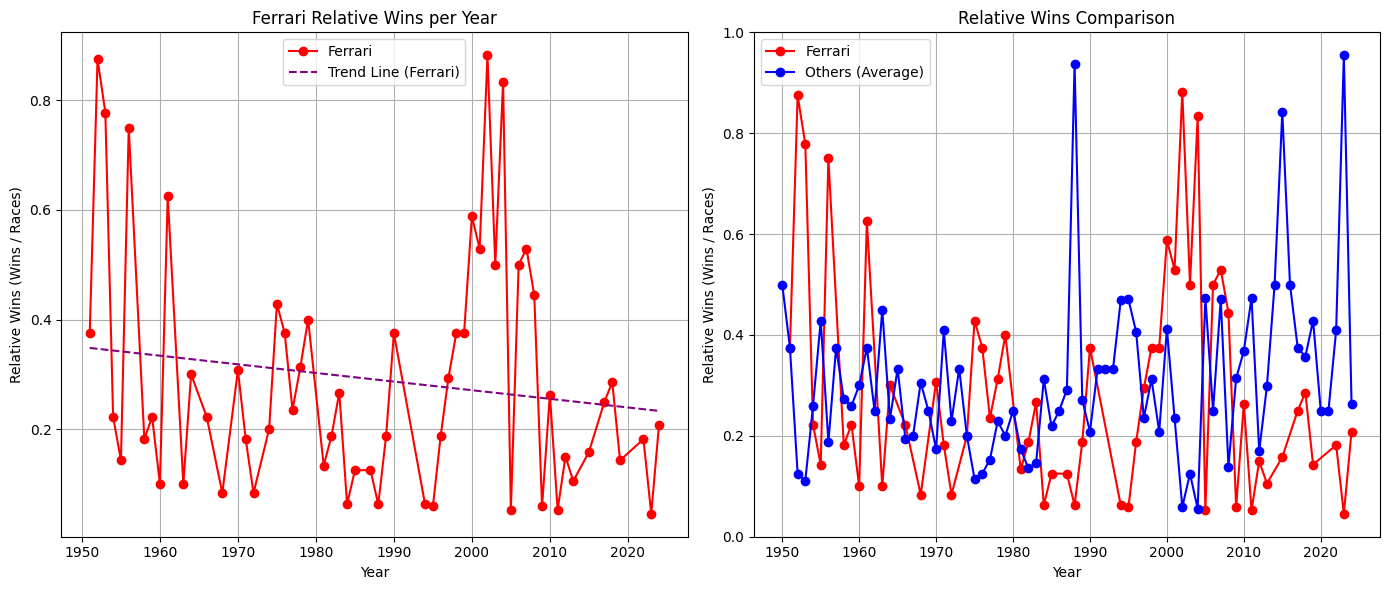

In [19]:
import matplotlib.pyplot as plt

ferrari_pdf = relative_ferrari_wins_df.toPandas()
others_pdf = relative_others_average_wins_df.toPandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(
    ferrari_pdf['year'],
    ferrari_pdf['relative_wins'],
    marker='o',
    linestyle='-',
    color='red',
    label='Ferrari'
)
axes[0].set_title('Ferrari Relative Wins per Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Relative Wins (Wins / Races)')

slope_value = lr_model.coefficients[0]
intercept_value = lr_model.intercept

years_for_plot = ferrari_pdf['year']
reg_line_predictions = [slope_value * yr + intercept_value for yr in years_for_plot]

axes[0].plot(
    years_for_plot,
    reg_line_predictions,
    color='purple',
    linestyle='--',
    label='Trend Line (Ferrari)'
)


axes[0].grid(True)
axes[0].legend()


axes[1].plot(
    ferrari_pdf['year'],
    ferrari_pdf['relative_wins'],
    marker='o',
    linestyle='-',
    color='red',
    label='Ferrari'
)
axes[1].plot(
    others_pdf['year'],
    others_pdf['relative_wins'],
    marker='o',
    linestyle='-',
    color='blue',
    label='Others (Average)'
)
axes[1].set_title('Relative Wins Comparison')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Relative Wins (Wins / Races)')
axes[1].grid(True)
axes[1].legend()



plt.tight_layout()
plt.show()


## Ferrari Drivers Championships

Here the points per driver will be used for each season as this information will be needed at a later point as well.

In [20]:
from pyspark.sql.window import Window
from pyspark.sql.functions import max, col

driver_standings_per_race = driver_standings_df.join(
    races_df,
    races_df.raceId == driver_standings_df.raceId,
    "inner"
)

window_by_year = Window.partitionBy("year")

with_max_round = driver_standings_per_race.withColumn(
    "max_round", max("round").over(window_by_year)
)

last_rounds_df = with_max_round.filter(col("round") == col("max_round")).drop("max_round")

driver_season_results_df = last_rounds_df.join(
    drivers_df,
    last_rounds_df.driverId == drivers_df.driverId,
    "inner"
).select(
    last_rounds_df.driverId,
    drivers_df.driverRef,
    last_rounds_df.year,
    driver_standings_df.position,
    driver_standings_df.points
).sort("year")
driver_season_results_df.show(5)
driver_champions_df = driver_season_results_df.where(driver_season_results_df.position == 1)

driver_champions_df.show(5)

+--------+---------+----+--------+------+
|driverId|driverRef|year|position|points|
+--------+---------+----+--------+------+
|     803| cantrell|1950|      74|   0.0|
|     666|     rolt|1950|      67|   0.0|
|     788|      fry|1950|      40|   0.0|
|     756|  pietsch|1950|      72|   0.0|
|     763|   sanesi|1950|      71|   0.0|
+--------+---------+----+--------+------+
only showing top 5 rows

+--------+---------+----+--------+------+
|driverId|driverRef|year|position|points|
+--------+---------+----+--------+------+
|     642|   farina|1950|       1|  30.0|
|     579|   fangio|1951|       1|  31.0|
|     647|   ascari|1952|       1|  36.0|
|     647|   ascari|1953|       1|  34.5|
|     579|   fangio|1954|       1|  42.0|
+--------+---------+----+--------+------+
only showing top 5 rows



In [21]:
ferrari_results_df = results_df.where(results_df.constructorId == ferrari).select("raceId", "driverId", "position")
ferrari_drivers_df = ferrari_results_df.join(drivers_df,
                                             drivers_df.driverId == ferrari_results_df.driverId,
                                             "inner").join(races_df,
                                             races_df.raceId == ferrari_results_df.raceId,
                                             "inner").select("position", "driverRef", "forename", "surname", "year", "date")

In the following step the dataframe is grouped so that only 2 drivers are listed per year. It is normal that every team has two drivers but sometimes a replacement driver needs to drive. To get meaningful results only the two main drivers will be shown. 

In [22]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, count

races_per_driver = ferrari_drivers_df.groupBy("year", "driverRef").agg(count("*").alias("race_count"))

window_spec = Window.partitionBy("year").orderBy(races_per_driver["race_count"].desc())
ranked = races_per_driver.withColumn("rank", row_number().over(window_spec))

top_2_per_year = ranked.filter("rank <= 2").select("year", "driverRef")
top_2_per_year.show(5)

+----+---------+
|year|driverRef|
+----+---------+
|1950|   ascari|
|1950|whitehead|
|1951|   ascari|
|1951|villoresi|
|1952|   farina|
+----+---------+
only showing top 5 rows



In [23]:
from pyspark.sql.functions import max, min

driver_span_df = top_2_per_year.groupBy("driverRef").agg(
    min("year").alias("startYear"),
    max("year").alias("endYear")
)

driver_span_df.show(5)

+----------+---------+-------+
| driverRef|startYear|endYear|
+----------+---------+-------+
|scarfiotti|     1967|   1967|
|     sainz|     2021|   2024|
|      ickx|     1968|   1973|
|    farina|     1952|   1955|
|      amon|     1967|   1969|
+----------+---------+-------+
only showing top 5 rows



Get all the Ferrari champions.

In [24]:
ferrari_champions_df = driver_champions_df.join(
    driver_span_df,
    (driver_champions_df.driverRef == driver_span_df.driverRef) &
    (driver_champions_df.year >= driver_span_df.startYear) &
    (driver_champions_df.year <= driver_span_df.endYear),
    how='inner'
)
ferrari_champions_df = ferrari_champions_df.select(
    driver_champions_df.driverId,
    driver_champions_df.driverRef,
    driver_champions_df.year,
    driver_champions_df.position,
    driver_champions_df.points
)

ferrari_champions_df.show()


+--------+------------------+----+--------+------+
|driverId|         driverRef|year|position|points|
+--------+------------------+----+--------+------+
|     578|          hawthorn|1958|       1|  42.0|
|      30|michael_schumacher|2000|       1| 108.0|
|      30|michael_schumacher|2001|       1| 123.0|
|      30|michael_schumacher|2002|       1| 144.0|
|      30|michael_schumacher|2003|       1|  93.0|
|      30|michael_schumacher|2004|       1| 148.0|
|       8|         raikkonen|2007|       1| 110.0|
|     341|           surtees|1964|       1|  40.0|
|     403|         phil_hill|1961|       1|  34.0|
|     579|            fangio|1956|       1|  30.0|
|     182|             lauda|1975|       1|  64.5|
|     182|             lauda|1977|       1|  72.0|
|     647|            ascari|1952|       1|  36.0|
|     647|            ascari|1953|       1|  34.5|
|     222|         scheckter|1979|       1|  51.0|
+--------+------------------+----+--------+------+



In [26]:
from pyspark.sql.functions import sum

df_with_periods = ferrari_champions_df.withColumn(
    "period",
    when((col("year") >= 1950) & (col("year") <= 1974), "Early Years (1950-1974)")
    .when((col("year") >= 1975) & (col("year") <= 1999), "Mid Years (1975-1999)")
    .when((col("year") >= 2000) & (col("year") <= 2024), "Recent Years (2000-2024)")
)
grouped_by_period_df = df_with_periods.groupBy("period").agg(
    sum("position").alias("ferrari_wins")
).orderBy("period")

print("\Wins per Defined Period:")
grouped_by_period_df.show()

\Wins per Defined Period:
+--------------------+------------+
|              period|ferrari_wins|
+--------------------+------------+
|Early Years (1950...|           6|
|Mid Years (1975-1...|           3|
|Recent Years (200...|           6|
+--------------------+------------+



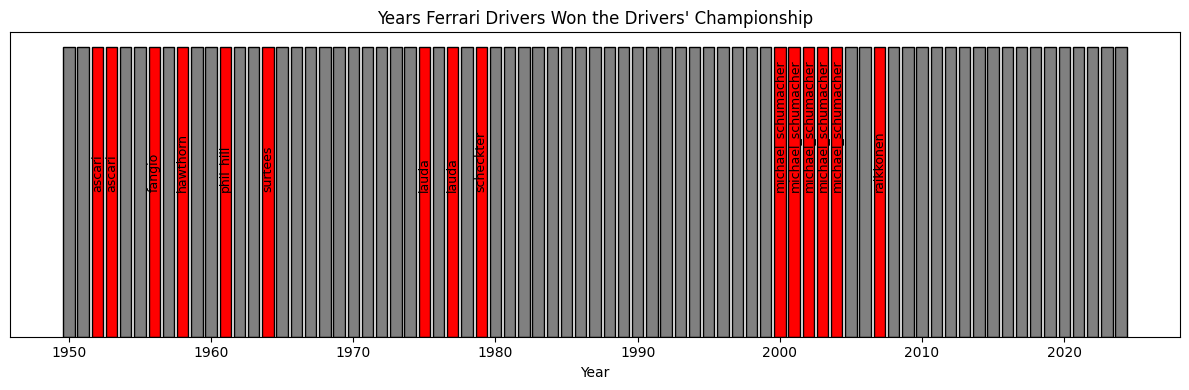

In [27]:
import matplotlib.pyplot as plt

driver_champions_pdf = driver_champions_df.toPandas()
ferrari_champions_pdf = ferrari_champions_df.toPandas()

driver_champions_pdf['is_ferrari'] = driver_champions_pdf['year'].isin(ferrari_champions_pdf['year'])

colors = ['red' if is_ferrari else 'gray' for is_ferrari in driver_champions_pdf['is_ferrari']]

plt.figure(figsize=(12, 4))
bars = plt.bar(driver_champions_pdf['year'], [1]*len(driver_champions_pdf), color=colors, edgecolor='black')

for i, row in driver_champions_pdf.iterrows():
    if row['is_ferrari']:
        plt.text(row['year'], 0.5, row['driverRef'], ha='center', va='bottom', fontsize=9, color='black', rotation=90)

plt.title('Years Ferrari Drivers Won the Drivers\' Championship')
plt.xlabel('Year')
plt.yticks([])
plt.tight_layout()
plt.show()

## Ferrari Constructor Championship

For the constructor championships only the winner of each season will be saved into the dataframe, as the points are not needed for any further research.

In [28]:
from pyspark.sql.window import Window
from pyspark.sql.functions import max


constructor_standings_per_race = constructor_standings_df.join(races_df,
               races_df.raceId == constructor_standings_df.raceId,
               "inner")

window_by_year = Window.partitionBy("year")

with_max_round = constructor_standings_per_race.withColumn(
    "max_round", max("round").over(window_by_year)
)

last_rounds_df = with_max_round.filter(col("round") == col("max_round")).drop("max_round")

constructor_season_results_df = last_rounds_df.join(constructors_df,
                                          last_rounds_df.constructorId == constructors_df.constructorId,
                                          "inner").select(last_rounds_df.constructorId, constructors_df.name, last_rounds_df.year, constructor_standings_df.position).sort("year")

constructor_wins_df = constructor_season_results_df.where(constructor_season_results_df.position == 1)
constructor_wins_df.show(5)

+-------------+-------------+----+--------+
|constructorId|         name|year|position|
+-------------+-------------+----+--------+
|          118|      Vanwall|1958|       1|
|          170|Cooper-Climax|1959|       1|
|          170|Cooper-Climax|1960|       1|
|            6|      Ferrari|1961|       1|
|           66|          BRM|1962|       1|
+-------------+-------------+----+--------+
only showing top 5 rows



Let's see who won the most constructor championships and where Ferrari stands.

In [29]:
count_constructor_wins_df = constructor_wins_df.groupBy("name").agg(count('*').alias('wins')).sort("wins", ascending=False)
count_constructor_wins_df.show(20)

+-------------+----+
|         name|wins|
+-------------+----+
|      Ferrari|  16|
|     Williams|   9|
|      McLaren|   9|
|     Mercedes|   8|
|     Red Bull|   6|
|   Team Lotus|   4|
|Brabham-Repco|   2|
|      Renault|   2|
| Lotus-Climax|   2|
|Cooper-Climax|   2|
|     Benetton|   1|
|   Matra-Ford|   1|
|        Brawn|   1|
|          BRM|   1|
|      Tyrrell|   1|
|      Vanwall|   1|
|   Lotus-Ford|   1|
+-------------+----+



Ferrari is a team that has been in Formula 1 for the longest time of any teams. So let's see the relative values for that. The constructors championship has been a awarded since 1958. Consideringh Ferrari has been driving constantly since 1951, it needs to be verifyied that Ferrari has 67 races.

In [30]:
count_races_per_constructor_df = constructor_season_results_df.groupBy("name").agg(count('*').alias('seasons')).sort("seasons", ascending=False)
count_races_per_constructor_df.sort("seasons", ascending=False).show(10)

+----------+-------+
|      name|seasons|
+----------+-------+
|   Ferrari|     67|
|   McLaren|     55|
|  Williams|     49|
|Team Lotus|     29|
|   Tyrrell|     29|
|   Renault|     24|
|    Sauber|     23|
|   Brabham|     22|
|    Ligier|     21|
|   Minardi|     21|
+----------+-------+
only showing top 10 rows



In [31]:
count_constructor_wins_df.count()

17

In [32]:
count_races_per_constructor_df.count()

160

In [33]:
constructors_wins_and_races_df = count_constructor_wins_df.join(count_races_per_constructor_df,
                                                                count_constructor_wins_df.name == count_races_per_constructor_df.name,
                                                                "inner").withColumn("rel_wins", col("wins") / col("seasons")).sort("rel_wins", ascending=False)
constructors_wins_and_races_df.show(17)

+-------------+----+-------------+-------+--------------------+
|         name|wins|         name|seasons|            rel_wins|
+-------------+----+-------------+-------+--------------------+
|        Brawn|   1|        Brawn|      1|                 1.0|
|     Mercedes|   8|     Mercedes|     15|  0.5333333333333333|
|   Matra-Ford|   1|   Matra-Ford|      2|                 0.5|
|Brabham-Repco|   2|Brabham-Repco|      4|                 0.5|
|      Vanwall|   1|      Vanwall|      3|  0.3333333333333333|
|     Red Bull|   6|     Red Bull|     20|                 0.3|
| Lotus-Climax|   2| Lotus-Climax|      7|  0.2857142857142857|
|      Ferrari|  16|      Ferrari|     67| 0.23880597014925373|
|Cooper-Climax|   2|Cooper-Climax|      9|  0.2222222222222222|
|     Williams|   9|     Williams|     49|  0.1836734693877551|
|   Lotus-Ford|   1|   Lotus-Ford|      6| 0.16666666666666666|
|      McLaren|   9|      McLaren|     55| 0.16363636363636364|
|   Team Lotus|   4|   Team Lotus|     2

In [34]:
df_with_periods = constructor_wins_df.where(constructor_wins_df.name == "Ferrari").withColumn(
    "period",
    when((col("year") >= 1950) & (col("year") <= 1974), "Early Years (1950-1974)")
    .when((col("year") >= 1975) & (col("year") <= 1999), "Mid Years (1975-1999)")
    .when((col("year") >= 2000) & (col("year") <= 2024), "Recent Years (2000-2024)")
)
grouped_by_period_df = df_with_periods.groupBy("period").agg(
    sum("position").alias("ferrari_wins")
).orderBy("period")

print("\Wins per Defined Period:")
grouped_by_period_df.show()

\Wins per Defined Period:
+--------------------+------------+
|              period|ferrari_wins|
+--------------------+------------+
|Early Years (1950...|           2|
|Mid Years (1975-1...|           7|
|Recent Years (200...|           7|
+--------------------+------------+



Let's visualise the constructor championships over the years.

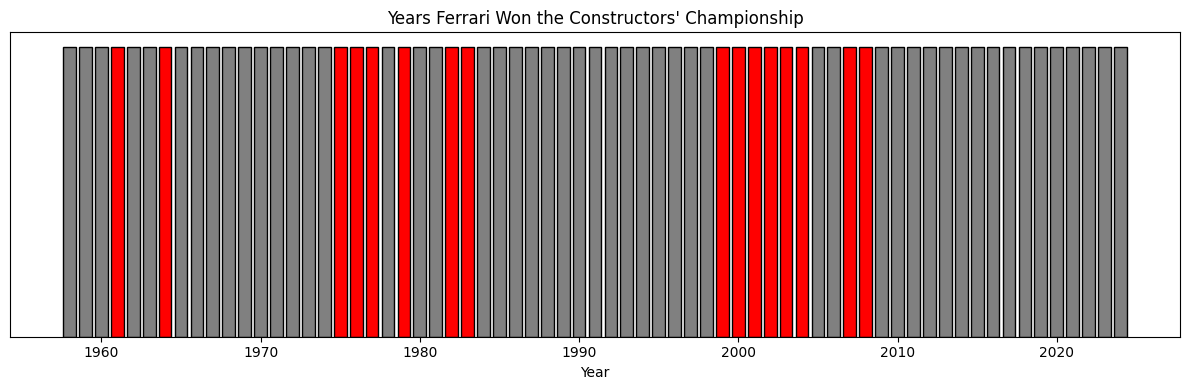

In [35]:
import matplotlib.pyplot as plt

constructor_wins_pdf = constructor_wins_df.toPandas()

constructor_wins_pdf['is_ferrari'] = constructor_wins_pdf['name'] == 'Ferrari'

colors = ['red' if is_ferrari else 'gray' for is_ferrari in constructor_wins_pdf['is_ferrari']]

plt.figure(figsize=(12, 4))
plt.bar(constructor_wins_pdf['year'], [1]*len(constructor_wins_pdf), color=colors, edgecolor='black')
plt.title('Years Ferrari Won the Constructors\' Championship')
plt.xlabel('Year')
plt.yticks([])
plt.tight_layout()
plt.show()

# Driver Dependencies

In this part the drivers of Ferrari will be investigated. This should show when Ferrari had which driver and how much their performance improved or worsened based on the driver.

In [36]:
results_df.show(1)

+--------+------+--------+-------------+------+----+--------+------------+-------------+------+----+-----------+------------+----------+----+--------------+---------------+--------+
|resultId|raceId|driverId|constructorId|number|grid|position|positionText|positionOrder|points|laps|       time|milliseconds|fastestLap|rank|fastestLapTime|fastestLapSpeed|statusId|
+--------+------+--------+-------------+------+----+--------+------------+-------------+------+----+-----------+------------+----------+----+--------------+---------------+--------+
|       1|    18|       1|            1|    22|   1|       1|           1|            1|  10.0|  58|1:34:50.616|     5690616|        39|   2|      1:27.452|        218.300|       1|
+--------+------+--------+-------------+------+----+--------+------------+-------------+------+----+-----------+------------+----------+----+--------------+---------------+--------+
only showing top 1 row



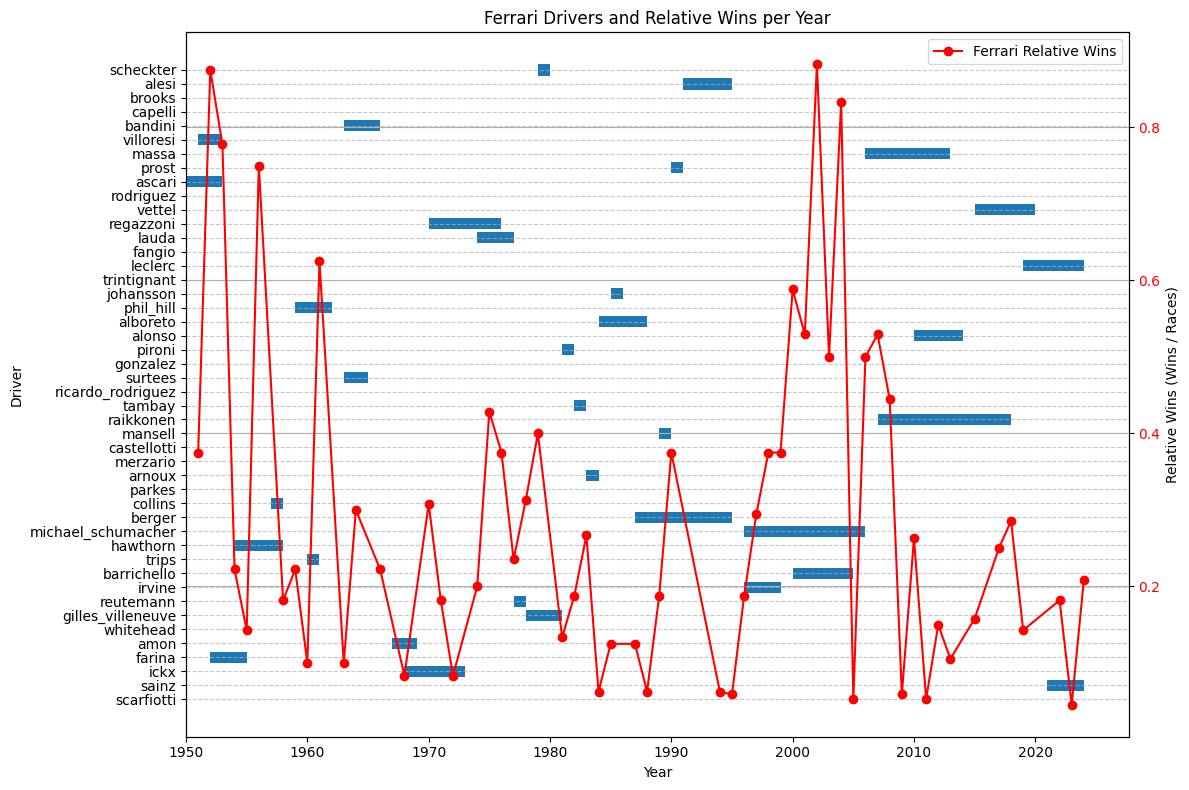

In [42]:
import matplotlib.pyplot as plt

driver_span_pdf = driver_span_df.toPandas()

fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.barh(
    y=driver_span_pdf['driverRef'],
    width=driver_span_pdf['endYear'] - driver_span_pdf['startYear'],
    left=driver_span_pdf['startYear'],
)
ax1.set_xlabel('Year')
ax1.set_ylabel('Driver')
ax1.set_title('Ferrari Drivers and Relative Wins per Year')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax2 = ax1.twinx()
ax2.plot(
    ferrari_pdf['year'],
    ferrari_pdf['relative_wins'],
    marker='o',
    linestyle='-',
    color='red',
    label='Ferrari Relative Wins'
)
ax2.set_ylabel('Relative Wins (Wins / Races)')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()

Comparing drivers and constructors champuionshop can show us if ferrari is able to win wihtout a driver winning, meaing: whole team and both drivers good and not being carried by one driver
use points instead of wins



In [43]:
driver_span_df.show(1)
constructor_season_results_df.show(5)
driver_season_results_df.show(5)

+----------+---------+-------+
| driverRef|startYear|endYear|
+----------+---------+-------+
|scarfiotti|     1967|   1967|
+----------+---------+-------+
only showing top 1 row

+-------------+----------+----+--------+
|constructorId|      name|year|position|
+-------------+----------+----+--------+
|           32|Team Lotus|1958|       6|
|          118|   Vanwall|1958|       1|
|          125| Connaught|1958|       8|
|          127|      OSCA|1958|       9|
|           95|   Porsche|1958|       7|
+-------------+----------+----+--------+
only showing top 5 rows

+--------+---------+----+--------+------+
|driverId|driverRef|year|position|points|
+--------+---------+----+--------+------+
|     803| cantrell|1950|      74|   0.0|
|     666|     rolt|1950|      67|   0.0|
|     788|      fry|1950|      40|   0.0|
|     756|  pietsch|1950|      72|   0.0|
|     763|   sanesi|1950|      71|   0.0|
+--------+---------+----+--------+------+
only showing top 5 rows



In [44]:
max_points_df = driver_season_results_df.groupBy("year").agg(
    max("points").alias("maxPoints")
)
max_points_df.show()

+----+---------+
|year|maxPoints|
+----+---------+
|1950|     30.0|
|1951|     31.0|
|1952|     36.0|
|1953|     34.5|
|1954|     42.0|
|1955|     40.0|
|1956|     30.0|
|1957|     40.0|
|1958|     42.0|
|1959|     31.0|
|1960|     43.0|
|1961|     34.0|
|1962|     42.0|
|1963|     54.0|
|1964|     40.0|
|1965|     54.0|
|1966|     42.0|
|1967|     51.0|
|1968|     48.0|
|1969|     63.0|
+----+---------+
only showing top 20 rows



In [45]:
top_2_with_max_points_df = top_2_per_year.join(
    max_points_df, 
    top_2_per_year.year == max_points_df.year, 
    "inner"
).select(top_2_per_year.year, top_2_per_year.driverRef, max_points_df.maxPoints)

top_2_with_max_points_df.show()

+----+-----------+---------+
|year|  driverRef|maxPoints|
+----+-----------+---------+
|1950|  whitehead|     30.0|
|1950|     ascari|     30.0|
|1951|  villoresi|     31.0|
|1951|     ascari|     31.0|
|1952|     ascari|     36.0|
|1952|     farina|     36.0|
|1953|     ascari|     34.5|
|1953|  villoresi|     34.5|
|1954|   hawthorn|     42.0|
|1954|   gonzalez|     42.0|
|1955|     farina|     40.0|
|1955|trintignant|     40.0|
|1956|castellotti|     30.0|
|1956|     fangio|     30.0|
|1957|   hawthorn|     40.0|
|1957|    collins|     40.0|
|1958|    collins|     42.0|
|1958|   hawthorn|     42.0|
|1959|  phil_hill|     31.0|
|1959|     brooks|     31.0|
+----+-----------+---------+
only showing top 20 rows



In [46]:
top_2_with_points_df = top_2_with_max_points_df.join(
    driver_season_results_df,
    (top_2_with_max_points_df.year == driver_season_results_df.year) &
    (top_2_with_max_points_df.driverRef == driver_season_results_df.driverRef),
    "inner"
).select(
    top_2_with_max_points_df.year, 
    top_2_with_max_points_df.driverRef, 
    "maxPoints", 
    "position", 
    "points"
)

top_2_with_points_df.sort("year").show(3)

+----+---------+---------+--------+------+
|year|driverRef|maxPoints|position|points|
+----+---------+---------+--------+------+
|1950|whitehead|     30.0|       9|   4.0|
|1950|   ascari|     30.0|       5|  11.0|
|1951|villoresi|     31.0|       5|  15.0|
+----+---------+---------+--------+------+
only showing top 3 rows



In [47]:
ferrari_constructor_wins_df = constructor_wins_df.where(constructor_wins_df.name == "Ferrari")
ferrari_constructor_wins_df.show(5)

+-------------+-------+----+--------+
|constructorId|   name|year|position|
+-------------+-------+----+--------+
|            6|Ferrari|1961|       1|
|            6|Ferrari|1964|       1|
|            6|Ferrari|1975|       1|
|            6|Ferrari|1976|       1|
|            6|Ferrari|1977|       1|
+-------------+-------+----+--------+
only showing top 5 rows



In [48]:
joined_df = top_2_with_points_df.join(
    ferrari_constructor_wins_df.select("year").withColumnRenamed("year", "ferrariWinYear"),
    top_2_with_points_df["year"] == col("ferrariWinYear"),
    "left"
)

result_with_ferrari_flag_df = joined_df.withColumn(
    "constructorChampionFerrari",
    col("ferrariWinYear").isNotNull()
).drop("ferrariWinYear")
result_with_ferrari_flag_df.sort("year").show(5)

+----+---------+---------+--------+------+--------------------------+
|year|driverRef|maxPoints|position|points|constructorChampionFerrari|
+----+---------+---------+--------+------+--------------------------+
|1950|whitehead|     30.0|       9|   4.0|                     false|
|1950|   ascari|     30.0|       5|  11.0|                     false|
|1951|villoresi|     31.0|       5|  15.0|                     false|
|1951|   ascari|     31.0|       2|  25.0|                     false|
|1952|   ascari|     36.0|       1|  36.0|                     false|
+----+---------+---------+--------+------+--------------------------+
only showing top 5 rows



In [49]:
from pyspark.sql.functions import col, max, first

max_points_per_year_df = result_with_ferrari_flag_df.groupBy("year").agg(
    max("points").alias("max_driver_points"),
    first("maxPoints").alias("yearly_max_points")
)

avg_points_per_year_df = result_with_ferrari_flag_df.groupBy("year").agg(
    avg("points").alias("avg_driver_points"),
    first("maxPoints").alias("yearly_max_points")
)

min_points_per_year_df = result_with_ferrari_flag_df.groupBy("year").agg(
    min("points").alias("min_driver_points"),
    first("maxPoints").alias("yearly_max_points")
)

In [50]:
avg_percentage_df = avg_points_per_year_df.withColumn(
    "percentage_of_max",
    when(col("yearly_max_points") != 0, col("avg_driver_points") / col("yearly_max_points"))
    .otherwise(None)
).select("year", "percentage_of_max")


max_percentage_df = max_points_per_year_df.withColumn(
    "percentage_of_max",
    when(col("yearly_max_points") != 0, col("max_driver_points") / col("yearly_max_points"))
    .otherwise(None)
).select("year", "percentage_of_max")

min_percentage_df = min_points_per_year_df.withColumn(
    "percentage_of_max",
    when(col("yearly_max_points") != 0, col("min_driver_points") / col("yearly_max_points"))
    .otherwise(None)
).select("year", "percentage_of_max")

In [51]:
avg_df_with_periods = avg_percentage_df.withColumn(
    "period",
    when((col("year") >= 1950) & (col("year") <= 1974), "Early Years (1950-1974)")
    .when((col("year") >= 1975) & (col("year") <= 1999), "Mid Years (1975-1999)")
    .when((col("year") >= 2000) & (col("year") <= 2024), "Recent Years (2000-2024)")
)
avg_grouped_by_period_df = avg_df_with_periods.groupBy("period").agg(
    avg("percentage_of_max").alias("percentage_of_max")
).orderBy("period")

min_df_with_periods = min_percentage_df.withColumn(
    "period",
    when((col("year") >= 1950) & (col("year") <= 1974), "Early Years (1950-1974)")
    .when((col("year") >= 1975) & (col("year") <= 1999), "Mid Years (1975-1999)")
    .when((col("year") >= 2000) & (col("year") <= 2024), "Recent Years (2000-2024)")
)
min_grouped_by_period_df = min_df_with_periods.groupBy("period").agg(
    avg("percentage_of_max").alias("percentage_of_max")
).orderBy("period")

max_df_with_periods = max_percentage_df.withColumn(
    "period",
    when((col("year") >= 1950) & (col("year") <= 1974), "Early Years (1950-1974)")
    .when((col("year") >= 1975) & (col("year") <= 1999), "Mid Years (1975-1999)")
    .when((col("year") >= 2000) & (col("year") <= 2024), "Recent Years (2000-2024)")
)
max_grouped_by_period_df = max_df_with_periods.groupBy("period").agg(
    avg("percentage_of_max").alias("percentage_of_max")
).orderBy("period")


print("\Percentag of max points for max Ferrari driver points:")
max_grouped_by_period_df.show()

print("\Percentag of max points for average Ferrari driver points:")
avg_grouped_by_period_df.show()

print("\Percentag of max points for min Ferrari driver points:")
min_grouped_by_period_df.show()


\Percentag of max points for max Ferrari driver points:
+--------------------+------------------+
|              period| percentage_of_max|
+--------------------+------------------+
|Early Years (1950...|0.5893940529365199|
|Mid Years (1975-1...|0.6325895268238629|
|Recent Years (200...|0.7459663516004815|
+--------------------+------------------+

\Percentag of max points for average Ferrari driver points:
+--------------------+-------------------+
|              period|  percentage_of_max|
+--------------------+-------------------+
|Early Years (1950...| 0.4707145312316767|
|Mid Years (1975-1...|0.48890279578623735|
|Recent Years (200...| 0.6165580970361192|
+--------------------+-------------------+

\Percentag of max points for min Ferrari driver points:
+--------------------+-------------------+
|              period|  percentage_of_max|
+--------------------+-------------------+
|Early Years (1950...| 0.3520350095268336|
|Mid Years (1975-1...|0.34521606474861166|
|Recent Years (2

In [52]:
assembler = VectorAssembler(
            inputCols=["year"],
            outputCol="features"
        )
regression_input_df = assembler.transform(max_percentage_df.select("year", "percentage_of_max")) \
                               .select(col("features"), col("percentage_of_max").alias("label"))

lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(regression_input_df)

# coefficient = slope
slope_value = lr_model.coefficients[0]

print(f"\nThe slope of percentage to max points of average points: {slope_value}")

# AVG
assembler = VectorAssembler(
            inputCols=["year"],
            outputCol="features"
        )
regression_input_df = assembler.transform(avg_percentage_df.select("year", "percentage_of_max")) \
                               .select(col("features"), col("percentage_of_max").alias("label"))

lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(regression_input_df)

# coefficient = slope
slope_value = lr_model.coefficients[0]

print(f"\nThe slope of percentage to avg points of average points: {slope_value}")

# MIN
assembler = VectorAssembler(
            inputCols=["year"],
            outputCol="features"
        )
regression_input_df = assembler.transform(min_percentage_df.select("year", "percentage_of_max")) \
                               .select(col("features"), col("percentage_of_max").alias("label"))

lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(regression_input_df)

# coefficient = slope
slope_value = lr_model.coefficients[0]

print(f"\nThe slope of percentage to min points of average points: {slope_value}")

25/05/18 19:03:02 WARN Instrumentation: [f2986f2f] regParam is zero, which might cause numerical instability and overfitting.



The slope of percentage to max points of average points: 0.001216842631843129


25/05/18 19:03:03 WARN Instrumentation: [0e44dcdb] regParam is zero, which might cause numerical instability and overfitting.



The slope of percentage to avg points of average points: 0.0014385064076291882


25/05/18 19:03:04 WARN Instrumentation: [ace99fcd] regParam is zero, which might cause numerical instability and overfitting.



The slope of percentage to min points of average points: 0.001660170183417013


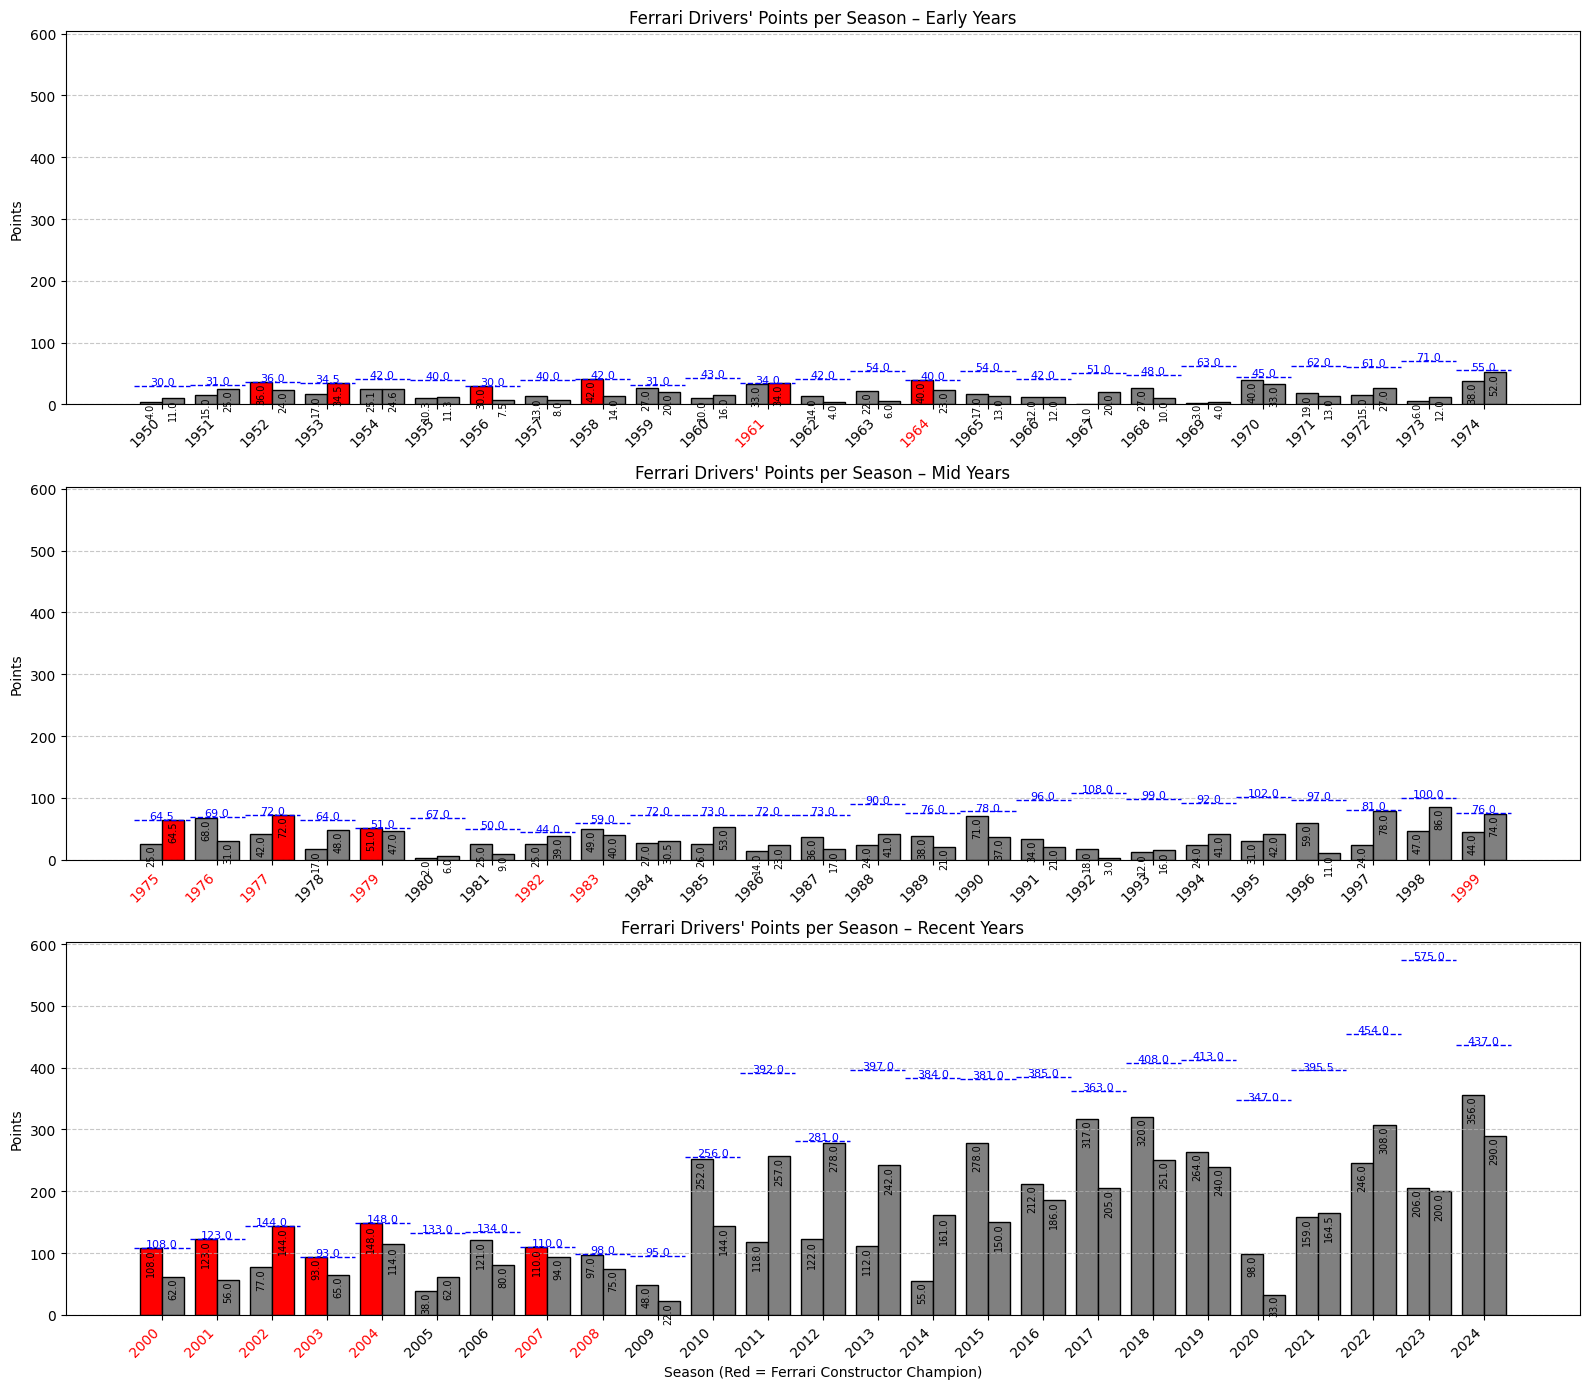

In [53]:
import matplotlib.pyplot as plt
import numpy as np

df = result_with_ferrari_flag_df.toPandas()

all_years = sorted(df["year"].unique())
n = len(all_years)
third = n // 3
chunks = [all_years[:third], all_years[third:2*third], all_years[2*third:]]

fig, axes = plt.subplots(3, 1, figsize=(16, 14), sharey=True)
bar_width = 0.4

for ax, years in zip(axes, chunks):
    x = np.arange(len(years))
    
    for i, year in enumerate(years):
        year_data = df[df["year"] == year].reset_index(drop=True)
        
        for j, row in year_data.iterrows():
            xpos = x[i] + (j - 0.5) * bar_width
            color = 'red' if row['position'] == 1 else 'gray'
            
            ax.bar(xpos, row['points'], width=bar_width, color=color, edgecolor='black')
                        
            ax.text(xpos, row['points'] - 1, f"{row['points']:.1f}", ha='center', va='top', fontsize=7, color='black', rotation=90)

        max_points = year_data["maxPoints"].iloc[0]
        ax.hlines(y=max_points, xmin=x[i] - 0.5, xmax=x[i] + 0.5, color='blue', linestyle='--', linewidth=1)
        ax.text(x[i], max_points + 1.5, max_points, ha='center', fontsize=8, color='blue')

    year_labels = []
    year_colors = []
    for year in years:
        won = df[(df["year"] == year)]["constructorChampionFerrari"].any()
        year_labels.append(str(year))
        year_colors.append('red' if won else 'black')

    ax.set_xticks(x)
    ax.set_xticklabels(year_labels, rotation=45, ha='right', color='black')
    
    for tick_label, color in zip(ax.get_xticklabels(), year_colors):
        tick_label.set_color(color)
    
    ax.set_ylabel("Points")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

axes[0].set_title("Ferrari Drivers' Points per Season – Early Years")
axes[1].set_title("Ferrari Drivers' Points per Season – Mid Years")
axes[2].set_title("Ferrari Drivers' Points per Season – Recent Years")
axes[2].set_xlabel("Season (Red = Ferrari Constructor Champion)")

plt.tight_layout()
plt.show()

Mid year were best with overall perfroamnce, had constructor without drivers, wbhilerecent yeuars had the michael schuhmacher era, they were nor able to d much without him, but the car and team was still good as discepency betwee ndrivers not that big

- max points further away:
   - specific teams more dominanting
   - new point system in 2009? link
   - maybe ferrari is jsut much worde
   - more races, so more points to get so bigger difference

# Qualifying

Compare to avg times of other teams, does it matter whether q1,2,3? q3 for good tezms and full speed

In [54]:
qualifying_df = spark.read.parquet(f"/f1/data/cleaned_qualifying.parquet")
qualifying_df.show(1)
qualifying_df.count()

+---------+------+--------+-------------+--------+--------+--------+--------+
|qualifyId|raceId|driverId|constructorId|position|      q1|      q2|      q3|
+---------+------+--------+-------------+--------+--------+--------+--------+
|        1|    18|       1|            1|       1|1:26.572|1:25.187|1:26.714|
+---------+------+--------+-------------+--------+--------+--------+--------+
only showing top 1 row



10494

We only want q3. This is where the drivers go all out and try their hardest.

In [55]:
q3_df = qualifying_df.where((qualifying_df.q3 != "NULL") & (qualifying_df.q3 != "\\N")).select("raceId", "driverId", "constructorId", "position", "q3")
q3_df.show(1)

q3_df.count()

+------+--------+-------------+--------+--------+
|raceId|driverId|constructorId|position|      q3|
+------+--------+-------------+--------+--------+
|    18|       1|            1|       1|1:26.714|
+------+--------+-------------+--------+--------+
only showing top 1 row



3629

In [56]:
q3_df.describe("q3").show()

+-------+--------+
|summary|      q3|
+-------+--------+
|  count|    3629|
|   mean|    NULL|
| stddev|    NULL|
|    min|0:53.377|
|    max|2:09.776|
+-------+--------+



In [57]:
q3_df.printSchema()

root
 |-- raceId: integer (nullable = true)
 |-- driverId: integer (nullable = true)
 |-- constructorId: integer (nullable = true)
 |-- position: integer (nullable = true)
 |-- q3: string (nullable = true)



Per race the average time for a lap will be calculated and then compared with the value of Ferrari's times.

In [58]:
from pyspark.sql.functions import col, unix_timestamp, split

df_with_seconds = q3_df.withColumn(
    "q3_seconds",
    split(col("q3"), ":").getItem(0).cast("int") * 60 + split(col("q3"), ":").getItem(1).cast("double")
)

avg_q3_df = df_with_seconds.groupBy("raceId").agg(
    (sum(col("q3_seconds")) / count(col("q3_seconds"))).alias("avg_q3_seconds")
)
avg_q3_df.describe("avg_q3_seconds").show()
avg_q3_df.show(1)

+-------+------------------+
|summary|    avg_q3_seconds|
+-------+------------------+
|  count|               374|
|   mean| 87.40904729755542|
| stddev|12.203561590472937|
|    min|53.784299999999995|
|    max|          127.9286|
+-------+------------------+

+------+-----------------+
|raceId|   avg_q3_seconds|
+------+-----------------+
|  1088|71.02033333333333|
+------+-----------------+
only showing top 1 row



In [59]:
qualifyings_with_race_df = races_df.join(
    avg_q3_df,
    "raceId",
    "inner").select(
    "raceId", "year", "name", "date", "quali_date", "avg_q3_seconds")

qualifyings_with_race_df.show(10)

+------+----+--------------------+----------+----------+-----------------+
|raceId|year|                name|      date|quali_date|   avg_q3_seconds|
+------+----+--------------------+----------+----------+-----------------+
|  1088|2022|    Dutch Grand Prix|2022-09-04|2022-09-03|71.02033333333333|
|   858|2011|Abu Dhabi Grand Prix|2011-11-13|        \N|99.39422222222224|
|   897|2013|Abu Dhabi Grand Prix|2013-11-03|        \N|         100.6261|
|  1025|2019|  Russian Grand Prix|2019-09-29|        \N|          92.7643|
|  1084|2022| Austrian Grand Prix|2022-07-10|2022-07-08|66.37377777777778|
|  1127|2024|Emilia Romagna Gr...|2024-05-19|2024-05-18|75.24629999999999|
|    31|2008|  Italian Grand Prix|2008-09-14|        \N|98.80050000000001|
|  1139|2024|United States Gra...|2024-10-20|2024-10-19|92.86833333333333|
|  1143|2024|    Qatar Grand Prix|2024-12-01|2024-11-30|80.97759999999998|
|    65|2006|Hungarian Grand Prix|2006-08-06|        \N|80.49090000000001|
+------+----+------------

In [60]:
from pyspark.sql.functions import col, unix_timestamp, split

ferrari_q3_df = q3_df.where(q3_df.constructorId == ferrari)

ferrari_df_with_seconds = ferrari_q3_df.withColumn(
    "q3_seconds",
    split(col("q3"), ":").getItem(0).cast("int") * 60 + split(col("q3"), ":").getItem(1).cast("double")
)

avg_ferrari_q3_df = ferrari_df_with_seconds.groupBy("raceId").agg(
    (sum(col("q3_seconds")) / count(col("q3_seconds"))).alias("avg_q3_seconds")
)
avg_ferrari_q3_df.describe("avg_q3_seconds").show()
avg_ferrari_q3_df.show(1)

+-------+------------------+
|summary|    avg_q3_seconds|
+-------+------------------+
|  count|               355|
|   mean| 86.87161690140843|
| stddev|11.944255611198452|
|    min|            53.613|
|    max|128.28300000000002|
+-------+------------------+

+------+--------------+
|raceId|avg_q3_seconds|
+------+--------------+
|  1088|       70.3985|
+------+--------------+
only showing top 1 row



In [61]:
ferrari_qualifyings_with_race_df = races_df.join(
    avg_ferrari_q3_df,
    "raceId",
    "inner").select(
    "raceId", "year", "name", "date", "quali_date", "avg_q3_seconds")

ferrari_qualifyings_with_race_df.show(10)

+------+----+--------------------+----------+----------+-----------------+
|raceId|year|                name|      date|quali_date|   avg_q3_seconds|
+------+----+--------------------+----------+----------+-----------------+
|  1088|2022|    Dutch Grand Prix|2022-09-04|2022-09-03|          70.3985|
|   858|2011|Abu Dhabi Grand Prix|2011-11-13|        \N|          99.3765|
|   897|2013|Abu Dhabi Grand Prix|2013-11-03|        \N|          101.015|
|  1025|2019|  Russian Grand Prix|2019-09-29|        \N|91.84049999999999|
|  1084|2022| Austrian Grand Prix|2022-07-10|2022-07-08|          65.0395|
|  1127|2024|Emilia Romagna Gr...|2024-05-19|2024-05-18|          75.1015|
|    31|2008|  Italian Grand Prix|2008-09-14|        \N|           98.894|
|  1139|2024|United States Gra...|2024-10-20|2024-10-19|           92.696|
|  1143|2024|    Qatar Grand Prix|2024-12-01|2024-11-30|          80.9465|
|    65|2006|Hungarian Grand Prix|2006-08-06|        \N|           79.886|
+------+----+------------

In [63]:
from pyspark.sql.functions import avg, col
from pyspark.sql.window import Window

ferrari_avg_q3_year = ferrari_qualifyings_with_race_df.groupBy("year").agg(
    avg("avg_q3_seconds").alias("ferrari_avg_q3")
).orderBy("year")

all_avg_q3_year = qualifyings_with_race_df.groupBy("year").agg(
    avg("avg_q3_seconds").alias("all_avg_q3")
).orderBy("year")

comparison_df = ferrari_avg_q3_year.join(all_avg_q3_year, "year", "inner")

comparison_df.show()

comparison_with_diff_df = comparison_df.withColumn(
    "difference", col("ferrari_avg_q3") - col("all_avg_q3")
).orderBy("year")

comparison_with_diff_df.show()

+----+-----------------+-----------------+
|year|   ferrari_avg_q3|       all_avg_q3|
+----+-----------------+-----------------+
|2007|84.62247058823529|85.30241045751634|
|2018|85.67257142857142|86.32205396825395|
|2015|89.50402777777778|89.84174583333335|
|2023|84.14227272727273|84.27689962121212|
|2006|      82.98559375|83.32267530864198|
|2022|85.78349999999999|86.52251856060604|
|2013|           92.879|92.99306827485378|
|2014|94.08530555555556|94.09849839181288|
|2019|        84.030325|83.98102078609222|
|2020|77.80354166666666|82.62521699346405|
|2012|92.27738235294117| 92.2710671626984|
|2009|89.57876666666668|91.22785686274509|
|2016|87.79759523809523|88.03577910052911|
|2024|83.81497727272728|83.78446631944445|
|2010|          89.6495|90.92234736842106|
|2011|89.25473684210529|89.27631102756892|
|2008|87.58852777777777|88.03358827160494|
|2017|86.27947500000002|86.90031499999999|
|2021|        82.011675|83.10472929292928|
+----+-----------------+-----------------+

+----+----

Grouping over time doesn't make sense as qualifying data starts in 2006 which is already in the epoch of recent years.

In [64]:
assembler = VectorAssembler(
            inputCols=["year"],
            outputCol="features"
        )
regression_input_df = assembler.transform(comparison_with_diff_df.select("year", "difference")) \
                               .select(col("features"), col("difference").alias("label"))

lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(regression_input_df)

# coefficient = slope
slope_value = lr_model.coefficients[0]

print(f"\nThe slope of qualifying time difference to the other team's average: {slope_value}")

25/05/18 19:03:53 WARN Instrumentation: [73ffec50] regParam is zero, which might cause numerical instability and overfitting.



The slope of qualifying time difference to the other team's average: -0.020556506138624257


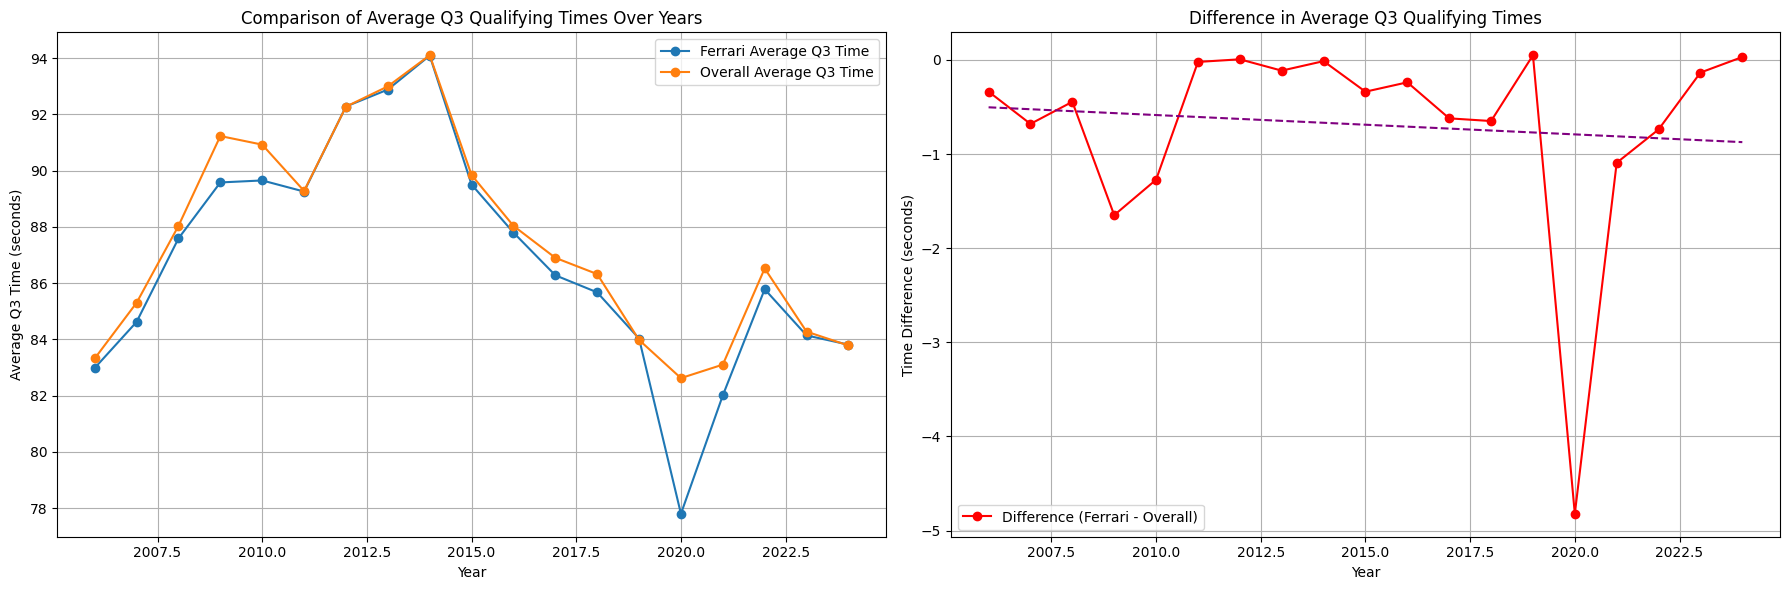

In [65]:
comparison_data = comparison_with_diff_df.collect()

years = [row.year for row in comparison_data]
avg_q3_ferrari = [row.ferrari_avg_q3 for row in comparison_data]
avg_q3_all = [row.all_avg_q3 for row in comparison_data]
difference = [row.difference for row in comparison_data]

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

axes[0].plot(years, avg_q3_ferrari, label='Ferrari Average Q3 Time', marker='o')
axes[0].plot(years, avg_q3_all, label='Overall Average Q3 Time', marker='o')
axes[0].set_ylabel('Average Q3 Time (seconds)')
axes[0].set_title('Comparison of Average Q3 Qualifying Times Over Years')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Year')

axes[1].plot(years, difference, label='Difference (Ferrari - Overall)', color='red', marker='o')
axes[1].set_ylabel('Time Difference (seconds)')
axes[1].set_title('Difference in Average Q3 Qualifying Times')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Year')

slope_value = lr_model.coefficients[0]
intercept_value = lr_model.intercept

reg_line_predictions = [slope_value * yr + intercept_value for yr in years]

axes[1].plot(
    years,
    reg_line_predictions,
    color='purple',
    linestyle='--',
    label='Trend Line (Ferrari)'
)

plt.tight_layout()
plt.show()

2020: Leclerc always pole, but not very good season otherwise

# Pitstops

Compare their average stop of a race to the other teams average, remove outliers

In [66]:
pit_stops_df = spark.read.parquet(f"/f1/data/cleaned_pit_stops.parquet")
pit_stops_df.show(1)

+------+--------+-------------------+--------+------------+----+---+
|raceId|driverId|               time|duration|milliseconds|stop|lap|
+------+--------+-------------------+--------+------------+----+---+
|   841|     153|2025-04-27 17:05:23|  26.898|       26898|   1|  1|
+------+--------+-------------------+--------+------------+----+---+
only showing top 1 row



In [67]:
pit_stops_df.count()

10619

In [68]:
pit_stops_df.describe("milliseconds").show()

+-------+------------------+
|summary|      milliseconds|
+-------+------------------+
|  count|             10619|
|   mean|24237.828985780205|
| stddev| 4385.253734099694|
|    min|             12897|
|    max|             87084|
+-------+------------------+



In [69]:
average_pit_stop_duration_per_race_df = pit_stops_df.groupBy("raceId").agg(
    avg("milliseconds").alias("average_pit_stop_duration_ms")
)

average_pit_stop_duration_per_race_df.show(5)

+------+----------------------------+
|raceId|average_pit_stop_duration_ms|
+------+----------------------------+
|  1088|                     19132.0|
|   858|          20523.780487804877|
|   897|                     22551.4|
|  1025|                     30764.0|
|  1084|          22529.658536585364|
+------+----------------------------+
only showing top 5 rows



In [70]:
average_pit_stop_duration_per_race_df.describe("average_pit_stop_duration_ms").show()

+-------+----------------------------+
|summary|average_pit_stop_duration_ms|
+-------+----------------------------+
|  count|                         285|
|   mean|          24513.024094823333|
| stddev|          3200.0648479067518|
|    min|           18541.68181818182|
|    max|          40056.179487179485|
+-------+----------------------------+



In [72]:
ferrari_drivers_df = top_2_per_year.join(drivers_df, "driverRef", "inner") \
    .select("year", "driverId")

pit_stops_with_year_df = pit_stops_df.join(races_df, "raceId", "inner") \
    .select("raceId", "driverId", "year", "milliseconds")

ferrari_pit_stops_df = pit_stops_with_year_df.join(
    ferrari_drivers_df, ["year", "driverId"], "inner"
).select("raceId", "driverId", "milliseconds")

average_ferrari_pit_stop_duration_per_race_df = ferrari_pit_stops_df.groupBy("raceId").agg(
    avg("milliseconds").alias("average_ferrari_pit_stop_duration_ms")
)

average_ferrari_pit_stop_duration_per_race_df.show(5)

+------+------------------------------------+
|raceId|average_ferrari_pit_stop_duration_ms|
+------+------------------------------------+
|  1088|                  20301.428571428572|
|   858|                            20507.75|
|   897|                            21695.75|
|  1025|                             29603.0|
|  1084|                             21441.0|
+------+------------------------------------+
only showing top 5 rows



In [73]:
all_avg_pit_stops_with_year_df = average_pit_stop_duration_per_race_df.join(
    races_df, "raceId", "inner"
).select("raceId", "average_pit_stop_duration_ms", "year")

ferrari_avg_pit_stops_with_year_df = average_ferrari_pit_stop_duration_per_race_df.join(
    races_df, "raceId", "inner"
).select("raceId", "average_ferrari_pit_stop_duration_ms", "year")

combined_avg_pit_stops_df = all_avg_pit_stops_with_year_df.join(
    ferrari_avg_pit_stops_with_year_df, ["raceId", "year"], "outer"
).select("raceId", "average_pit_stop_duration_ms", "average_ferrari_pit_stop_duration_ms", "year").sort("year")

combined_avg_pit_stops_df.show()

+------+----------------------------+------------------------------------+----+
|raceId|average_pit_stop_duration_ms|average_ferrari_pit_stop_duration_ms|year|
+------+----------------------------+------------------------------------+----+
|   841|          24035.704545454544|                  24100.333333333332|2011|
|   842|          24186.293103448275|                   24671.14285714286|2011|
|   843|                     22097.0|                            21641.75|2011|
|   844|                  22327.5125|                           22452.625|2011|
|   845|          21457.486842105263|                   20968.14285714286|2011|
|   846|          27079.833333333332|                             27783.0|2011|
|   847|          24648.342465753423|                  24986.285714285714|2011|
|   848|          21556.079365079364|                             21470.5|2011|
|   849|           25599.56603773585|                  24223.333333333332|2011|
|   850|          21426.408163265307|   

In [74]:
yearly_avg_all_pit_stops_df = combined_avg_pit_stops_df.groupBy("year").agg(
    avg("average_pit_stop_duration_ms").alias("yearly_avg_all_pit_stop_duration_ms")
).orderBy("year")

yearly_avg_ferrari_pit_stops_df = combined_avg_pit_stops_df.groupBy("year").agg(
    avg("average_ferrari_pit_stop_duration_ms").alias("yearly_avg_ferrari_pit_stop_duration_ms")
).orderBy("year")

yearly_avg_pit_stops_comparison_df = yearly_avg_all_pit_stops_df.join(
    yearly_avg_ferrari_pit_stops_df, "year", "outer"
).orderBy("year")

yearly_avg_pit_stops_with_difference_df = yearly_avg_pit_stops_comparison_df.withColumn(
    "difference_ms",
    col("yearly_avg_ferrari_pit_stop_duration_ms") - col("yearly_avg_all_pit_stop_duration_ms")
)

yearly_avg_pit_stops_with_difference_df.show()

+----+-----------------------------------+---------------------------------------+-------------------+
|year|yearly_avg_all_pit_stop_duration_ms|yearly_avg_ferrari_pit_stop_duration_ms|      difference_ms|
+----+-----------------------------------+---------------------------------------+-------------------+
|2011|                   23272.8535376333|                      22877.09937343358| -395.7541641997195|
|2012|                  22998.14270007575|                     21990.991785714286| -1007.150914361464|
|2013|                 23643.918623029636|                     22623.966228070174|-1019.9523949594623|
|2014|                 25012.867466647673|                     24775.094736842104|-237.77272980556882|
|2015|                 25402.660099793637|                      25204.99956140351|-197.66053839012602|
|2016|                  24642.99837342054|                      24809.81179138322| 166.81341796267952|
|2017|                  24281.98674323291|                      23671.505

Grouping doesn't make sense, as earliest value is in 2011.

In [75]:
assembler = VectorAssembler(
            inputCols=["year"],
            outputCol="features"
        )
regression_input_df = assembler.transform(yearly_avg_pit_stops_with_difference_df.select("year", "difference_ms")) \
                               .select(col("features"), col("difference_ms").alias("label"))

lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(regression_input_df)

# coefficient = slope
slope_value = lr_model.coefficients[0]

print(f"\nThe slope of pit stops time compared to other teams: {slope_value}")

25/05/18 19:04:25 WARN Instrumentation: [d7ef9cfb] regParam is zero, which might cause numerical instability and overfitting.



The slope of pit stops time compared to other teams: 4.105822021293901


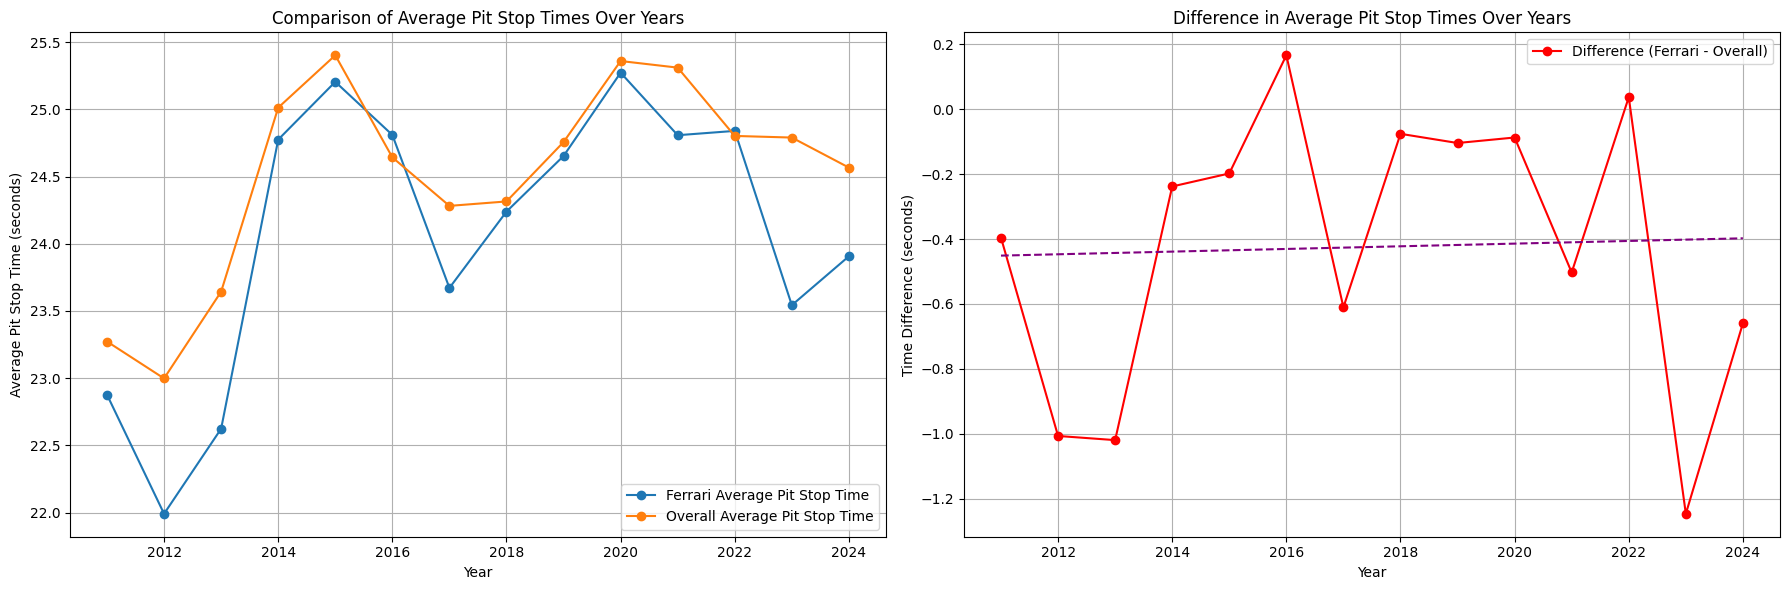

In [76]:
import matplotlib.pyplot as plt

yearly_pit_stop_data = yearly_avg_pit_stops_with_difference_df.collect()

years_pitstop = [row.year for row in yearly_pit_stop_data]
avg_pit_stop_all = [row.yearly_avg_all_pit_stop_duration_ms / 1000 if row.yearly_avg_all_pit_stop_duration_ms is not None else None for row in yearly_pit_stop_data] # Convert ms to seconds
avg_pit_stop_ferrari = [row.yearly_avg_ferrari_pit_stop_duration_ms / 1000 if row.yearly_avg_ferrari_pit_stop_duration_ms is not None else None for row in yearly_pit_stop_data] # Convert ms to seconds
difference_pitstop = [row.difference_ms / 1000 if row.difference_ms is not None else None for row in yearly_pit_stop_data]

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

axes[0].plot(years_pitstop, avg_pit_stop_ferrari, label='Ferrari Average Pit Stop Time', marker='o')
axes[0].plot(years_pitstop, avg_pit_stop_all, label='Overall Average Pit Stop Time', marker='o')
axes[0].set_ylabel('Average Pit Stop Time (seconds)')
axes[0].set_title('Comparison of Average Pit Stop Times Over Years')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Year')

axes[1].plot(years_pitstop, difference_pitstop, label='Difference (Ferrari - Overall)', color='red', marker='o')
axes[1].set_ylabel('Time Difference (seconds)')
axes[1].set_title('Difference in Average Pit Stop Times Over Years')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Year')

slope_value = lr_model.coefficients[0]
intercept_value = lr_model.intercept
reg_line_predictions_seconds = [(slope_value * year + intercept_value) / 1000.0 for year in years_pitstop]
axes[1].plot(years_pitstop, reg_line_predictions_seconds, color='purple', linestyle='--')

plt.tight_layout()
plt.show()

Based on the data that was used (cleaned by just removing outliers/weird values), it can be ...

# Conclusion

